# Classifying Cardiovascular Diseases in a Simple Way!

## Introduction

Cardiovascular diseases (CVDs) collectively describe a group of disorders involving the heart and the blood vessels surrounding it. Research around cariovascular diseases have been a subject of great interest as it is estimated that 17.9 million lives are claimed by CVDs each year worldwide (1). The presence of CVDs correlate with age, cardiovasular related hereditary diseases (type 2 diabetes, thalassemisa, Etc.), and with some behavioral risk factors such as smoking, unhealthy diet, lack of physical exercise, and excessive alcohol consumption (1). It is also noted that individuals with these behavioral risk factors may also present symptoms such as high blood pressure, high blood glucose, high blood lipids, and obesity (1).

Common tests to diagnose CVDs include blood work, electrocardiogram, ambulatory monitoring, echocardiogram, cardiac CT's and MRI's, stress tests, and cardiac catheterization (1). However, an accurate diagnosis still require much manual analysis integrating laboratory data and patient information (1). Thus, manual diagnosis can be complex and time consuming while depending on the examining physician's knowledge and experience. Moreover, in facilities with limited resources, the accuracy for diagnosis and treatment of CVDs would suffer. One can imagine that with a lack of diagnostic apparatuses, low physician-to-patient ratios, and shortage of medical expertise can result in poor prediction and treatment of heart patients. Here we explore whether a model that consumes several simple predictors (gathered without advanced machinaries and high quality expertise) could accurately predict the presence of CVDs in patients. The model which we will develop in this report will be a classifier which uses K-Nearest Neighbors (KNN). We opted for a classification model rather than a regression model as the predicted vector is a categorical type and not a numerical type. All the columns in our tidied data set (except for the predicted vector) will be used as predictors.

The datasets which we will use to develop our classifier are taken from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). The data was collected from patients in the following locations:

1. Cleveland Clinic Foundation
2. Hungarian Institute of Cardiology, Budapest
3. V.A. Medical Center, Long Beach, CA
4. University Hospital, Zurich, Switzerland

Each location compiled a separate database that contain 76 recorded attributes for each patient in their list of heart patients. For our purposes, we are going to focus on a subset of 7 attributes from a combined dataset from all four locations. These variables The 7 attributes are as follows:

1. `age` - age of patients
2. `sex` - sex of patients
3. `exang` - exercised induced angina. Angina is a type of chest pain caused by reduced blood flow to the heart.
4. `oldpeak` - ST depression induced by exercise relative to rest. A measurement taken from a patient's electrocardiogram.
5. `slope` - Slope of the peak exercise ST segment. A measurement taken from a patient's electrocardiogram.
6. `num` - catoregorization of the severity of CVD in 0 to 4, with "0" being free of CVD.

The reasoning behind the choices of these variables to serve as our predictors came down to several factors: relevance to CVD's, high convenience in acquiring measurement for each predictors, and significant differences of relative incidences of CVD within each predictor's subcategories. For example, one could intuitively generalize that older individuals would be more sickly than younger individuals as their physique and immunity decreases with age and so this might be the case of prevalence of CVD's. There are different biological markers between biological sexes which may lead to higher risk factors for CVD's (2). Angina is a type of chest pain caused by reduced blood flow to the heart, which shouldn't be frequently induced in healthy individuals (3). Electrocardiogram is one of the cheapest, simplest, non-invasive, and fastest tests to evaluate the heart by its electrical activities (4). Individually, none of these predictors would reliably detect the presence of CVD's. However, concatenating these predictors in a classifier, we might be able to isolate a "finger print pattern" which could reliably detect CVD's.

## Wrangling and Tidying Data

To tidy our data we:
- Added an origin category for each observation.
- Combined four datasets into one mega data set.
- Renamed each column so they are more readible and select the columns of interest.
- Removed all observations which doesn't contain the a value for every predictor.
- Converted the vector type for each column so they could be pass to the `recipe` function.

The code for each manipulation is as follows:

In [1]:
#Loading Packages
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(knitr)

#Loading the Data
cleveland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
hungarian <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)
switzerland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = FALSE)
va <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Adding an origin category for each row/combining dataset into one
cleveland_data <- mutate(cleveland, Origin = "cleveland")
hungarian_data <- mutate(hungarian, Origin = "hungarian")
switzerland_data <- mutate(switzerland, Origin = "switzerland")
va_data <- mutate(va, Origin = "longbeach")
mega <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data)

#Adding names to each column & selecting columns of interest
column_names = c("age", "sex", "X3", "X4", "X5", "X6", "X7", "X8", "exercise_induced_angina", "st_depression", "st_segment_slope", "X12", "X13", "presence_of_cvd", "origin")
colnames(mega) <- column_names
mega_data <- mega |> select(age, sex, exercise_induced_angina, st_depression, st_segment_slope, presence_of_cvd, origin)

#Removing all rows that with at least one missing variable in any column.
tidy_data <- mega_data |> filter(exercise_induced_angina != "?" & st_depression != "?" & st_segment_slope != "?")

#Combining heart severity levels 1 to 4 into one measurement and vari in presence_of_cvd into "Yes" or "No"
severity_1_to_4 <- tidy_data |> filter(presence_of_cvd != 0) |> mutate(presence_of_cvd = "Yes")
tidy_data_final <- tidy_data |> filter(presence_of_cvd == 0) |> mutate(presence_of_cvd = "No") |> rbind(severity_1_to_4)

#Converting column into workable vectors
tidy_data_final <- tidy_data_final |> 
    mutate(presence_of_cvd = as_factor(presence_of_cvd)) |>
    mutate(exercise_induced_angina = as.double(exercise_induced_angina)) |>
    mutate(st_depression = as.double(st_depression)) |>
    mutate(st_segment_slope = as.double(st_segment_slope))
head(tidy_data_final)

age,sex,exercise_induced_angina,st_depression,st_segment_slope,presence_of_cvd,origin
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
63,1,0,2.3,3,No,cleveland
37,1,0,3.5,3,No,cleveland
41,0,0,1.4,1,No,cleveland
56,1,0,0.8,1,No,cleveland
57,0,1,0.6,1,No,cleveland
57,1,0,0.4,2,No,cleveland


*Table 1: First 6 rows of tidied dataset*

From Table 1, we see our data set is now tidy as it meets the three criteria for tidy data:
- Each row is a single observation.
- Each column is a single variable.
- Each value is a single cell.

## Summary of Dataset

We decided on a 75-25 split of the tidied data, and used the larger set as the training set to maximize the accuracy of our classifier.

In [3]:
#Creating training and testing data set. 
set.seed(1)
split_data <- initial_split(tidy_data_final, prop = 0.80, strata = presence_of_cvd)
training_data <- training(split_data)
testing_data <- testing(split_data)

Here we generated a table to see how many rows were removed during the tidying process.

In [4]:
#Summary of number of rows in the mega data set, tidied data set, deleted rows from mega data set to create tidied data set, and training data set.
nrows_in_raw_data <- nrow(mega_data)
nrows_in_tidy_data <- nrow(tidy_data_final)
nrows_in_training <- nrow(training_data)
nrows_in_testing <- nrow(testing_data)
raw_stats <- data.frame(nrows_in_raw_data, nrows_in_tidy_data, nrows_in_training, nrows_in_testing) |> 
    mutate(nrows_with_missing_data = nrows_in_raw_data - nrows_in_tidy_data) |>
    select(nrows_in_raw_data, nrows_with_missing_data, nrows_in_tidy_data, nrows_in_training, nrows_in_testing)
raw_stats

nrows_in_raw_data,nrows_with_missing_data,nrows_in_tidy_data,nrows_in_training,nrows_in_testing
<int>,<int>,<int>,<int>,<int>
920,310,610,487,123


*Table 2: Summary of number of rows in raw data, tidy Data, training Set, and testing Set*

From Table 2, we can see that a significant number of rows were removed from the initial mega dataset we created. However, we still ended up with tidied 610 observations with 487 observation in our training set. This quantity should be an adequate number of data points to carry forward with creating the classifier. 

Another potential issue in a data set for a classifier could be class imbalance. To check class balance in our training set we generated another table:

In [5]:
#Summary of patients with CVD in training data set
training_stats <- training_data |> 
    group_by(presence_of_cvd) |> 
    count() |> 
    pivot_wider(names_from = presence_of_cvd, values_from = n) |> 
    rename(CVD_true = Yes, CVD_false = No) |> 
    mutate(total_count = nrows_in_training)
training_stats

CVD_false,CVD_true,total_count
<int>,<int>,<int>
173,314,487


*Table 3: Class distribution in training set*

In Table 3, we see higher counts for `CVD_false` (0.64) than counts for `CVD_true` (0.36). However, we are going assume that class of `CVD_true` is abundant enough that there shouldn't be significant bias toward the other class. Some bias could be mitigated by using higher K-neighbor values in our classifier.

## Visualing the Relationship of Predictors with the Predicted Variable

We chose to visualize the relationship between our predictors and the predicted variable using histograms and bar graphs. The main decision to use histograms for `age`, and `ST_depression` was because their values were quite spread. Using histograms, we wanted to visualize the distribution of these predictors. The main decision to use bar graphs for `sex`, `ST_segment_Slopes`, and `exercise_induced_angina` was because the values of these predictors could be counted in selective groups. By setting our predicted variable to `fill`, we could visualize the relative distribution our predicted variable in each of those groups.

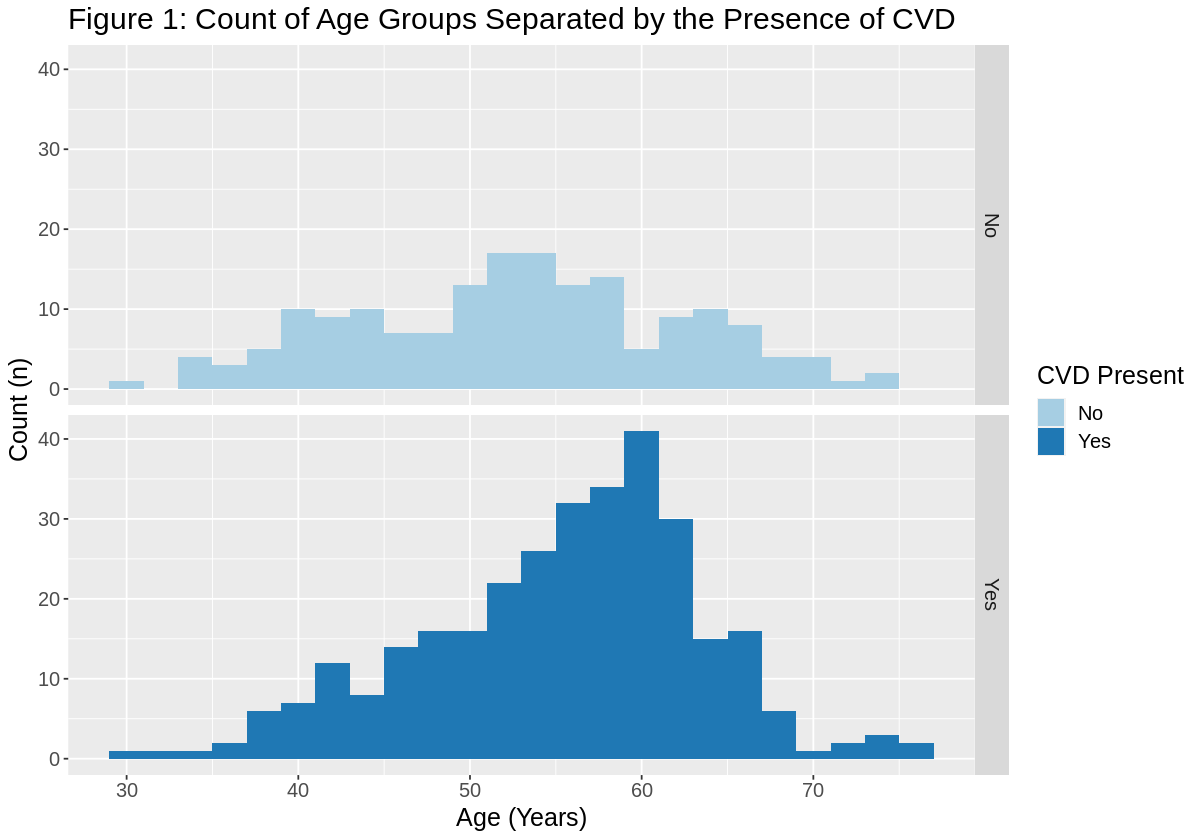

In [6]:
#Age vs. presence of CVD.
options(repr.plot.width = 10, repr.plot.height = 7)
age_vs_pred <- training_data |>
    ggplot(aes(x = age, fill = as_factor(presence_of_cvd))) +
    geom_histogram(bins = 25) + 
    labs(x = "Age (Years)", y = "Count (n)", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Figure 1: Count of Age Groups Separated by the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired') +
    facet_grid(rows = vars(presence_of_cvd))
age_vs_pred

In Figure 1, by using the `facet_grid` function to separate the distributions of age by the `presence_of_cvd`, we see that the distribution of the `Yes` group for CVD present is skewed to the left, and the distribution of the `no` group for CVD present is roughly bell-shaped.

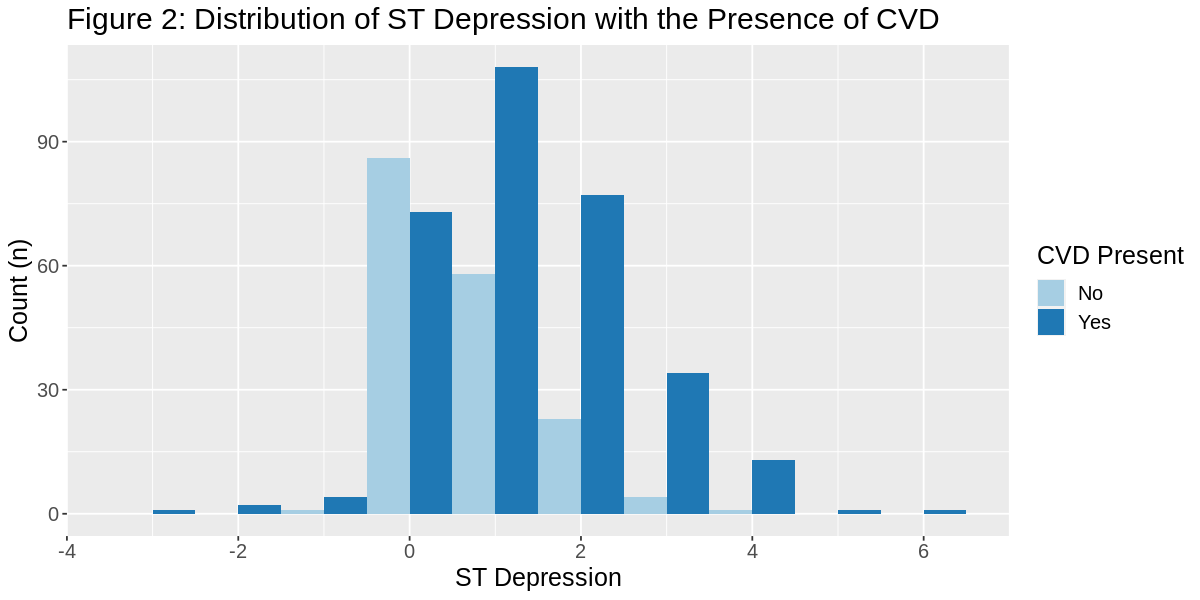

In [7]:
#ST depression vs. presence of CVD.
options(repr.plot.width = 10, repr.plot.height = 5)
st_depression_plot <- ggplot(training_data, aes(x = st_depression, fill = as_factor(presence_of_cvd))) +
    geom_histogram(binwidth = 1, position = "dodge") + 
    labs(x = "ST Depression", y = "Count (n)", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Figure 2: Distribution of ST Depression with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_depression_plot

We decided to the separate the distribution by setting `position = "dodge"` in the `geom_histogram` function instead of using the `facet_grid` function as there were gaps between certain ranges. This way we can better see from Figure 2 that there is a certain range of ST depression (approximately 0 to 1) that has the least relative presence of CVD.

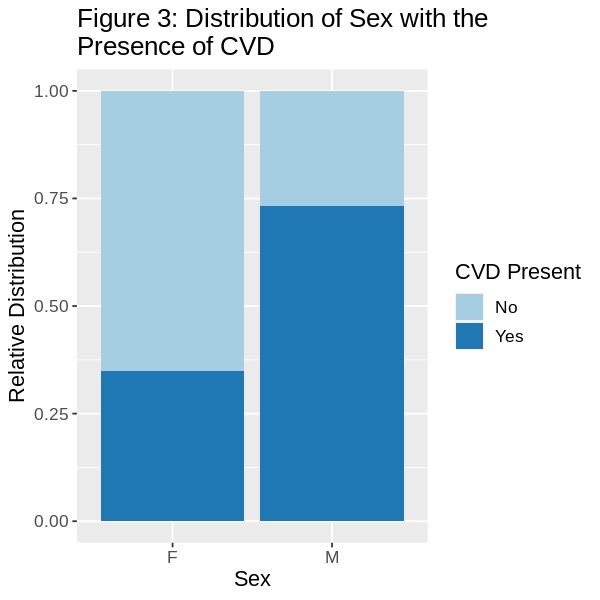

In [8]:
#Converting the values into intuitive names.
males <- training_data |> filter(sex != 0) |> mutate(sex = "M")
sex_data <- training_data |> filter(sex == 0) |> mutate(sex = "F") |> rbind(males)

#Sex vs. presence of CVD.
options(repr.plot.width = 5, repr.plot.height = 5)
sex_plot <- ggplot(sex_data, aes(x = sex, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Sex", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 13)) +
    ggtitle("Figure 3: Distribution of Sex with the  \nPresence of CVD") +
    scale_fill_brewer(palette = 'Paired')
sex_plot

In Figure 3, by setting `position = "fill"`, we see that the relative presence of CVD is higher in males.

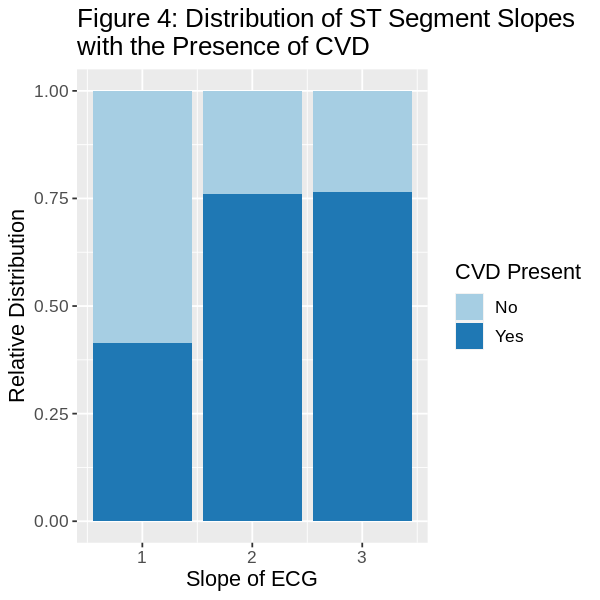

In [9]:
#ST slope versus presence of CVD.
st_segment_slope_plot <- ggplot(training_data, aes(x = st_segment_slope, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Slope of ECG", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 13)) +
    ggtitle("Figure 4: Distribution of ST Segment Slopes  \nwith the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_segment_slope_plot

In Figure 4, by setting `position = "fill"`, we can see that slopes >1 have increased relative presence of CVD.

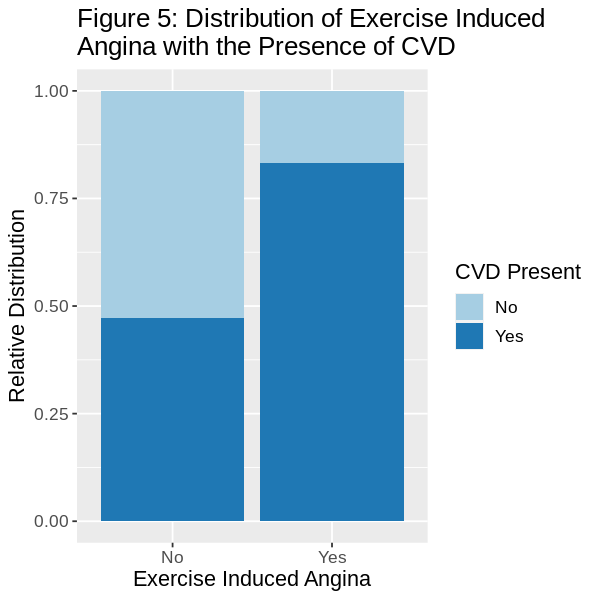

In [10]:
#Converting the values into intuitive names.
not_induced <- training_data |> filter(exercise_induced_angina == 0) |> mutate(exercise_induced_angina = "No")
exercise_data <- training_data |> filter(exercise_induced_angina == 1) |> mutate(exercise_induced_angina = "Yes") |> rbind(not_induced)

#Exercise induced angina vs. presence of CVD.
exercise_induced_angina_plot <- ggplot(exercise_data, aes(x = exercise_induced_angina, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Exercise Induced Angina", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 13)) +
    ggtitle("Figure 5: Distribution of Exercise Induced \nAngina with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
exercise_induced_angina_plot

In Figure 5, by setting `position = "fill"`, we can see that presence of exercise induced angina has a significantly higher relative presence of CVD.

From these visualizations, we can confirm that these vectors contain ranges or groups with significantly higher relative presence of CVD. This ultimately implies that these vectors could be used as predictors in our classifier.

## Coding the Classifier

We initially conducted a 5-fold cross validation to determine the optimal number of `K-neighbours` to use. In our recipe we also standardized our predictors. Some of our predictors contained values which could be categorized into binary values (0 and 1 for no and yes, respectively) while other predictor's values ranged from 0 to 80 or -2.5 to 7. Thus standarization was deemed necessary to prevent any single predictor from having a larger influence than other predictors in determining the outcome of the prediction.

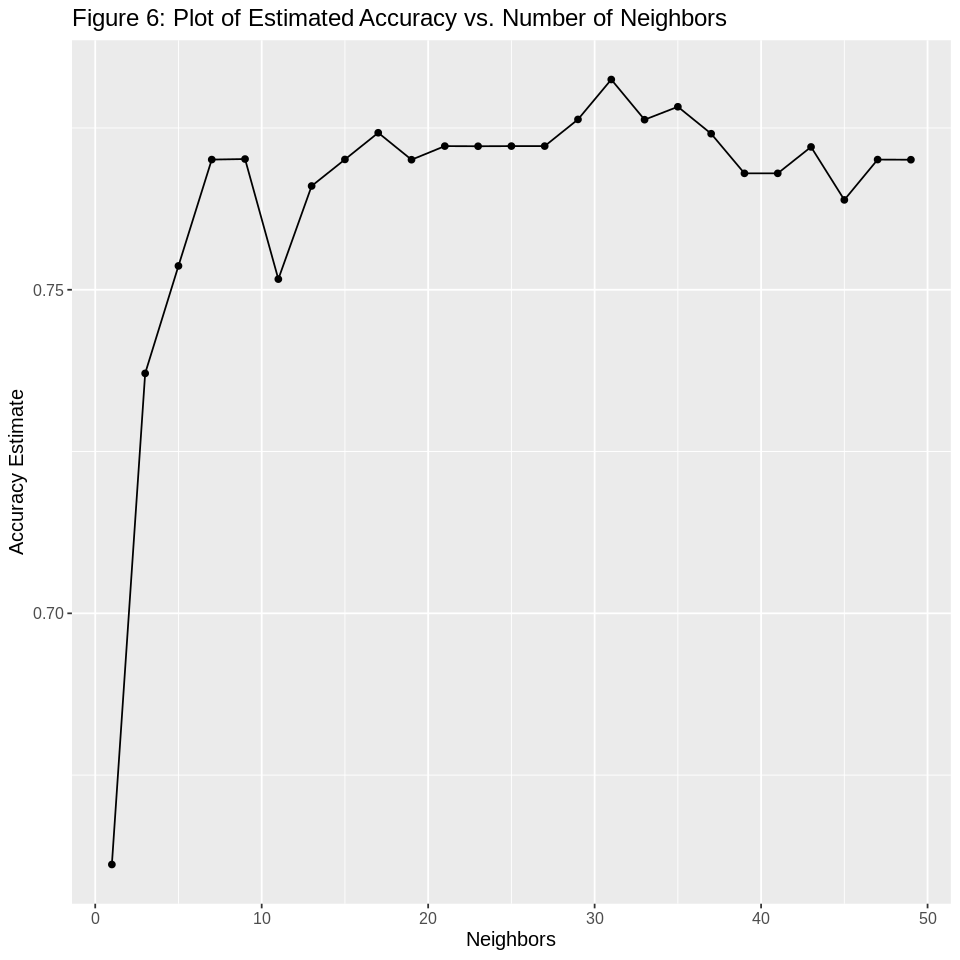

In [11]:
set.seed(2)

#5-fold Cross Validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

cvd_recipe <- recipe(presence_of_cvd ~ age + sex + exercise_induced_angina +st_depression + st_segment_slope, data = training_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

cvd_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_cvd)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

knn_results <- workflow() |>
    add_recipe(cvd_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cvd_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

options(repr.plot.width = 8, repr.plot.height = 8)
accuracy_vs_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12)) +
    ggtitle("Figure 6: Plot of Estimated Accuracy vs. Number of Neighbors")
accuracy_vs_k

From Figure 6, we decided to use K = 24 as changing the number of neighbors by 1 or 2 didn't cause the accuracy to fluctuate greatly.

In [12]:
#Predict of Test Set and Summary of Test Set
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 24) |> 
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_2 <- workflow() |>
    add_recipe(cvd_recipe) |>
    add_model(knn_spec_2) |>
    fit(data = training_data) 

cvd_test_predictions <- predict(knn_fit_2, testing_data) |>
    bind_cols(testing_data)

accuracy_results <- cvd_test_predictions |>
    metrics(truth = presence_of_cvd, estimate = .pred_class) |>
    filter(.metric == "accuracy")
accuracy_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8211382


*Table 4: Accuracy of Predicting Test Set*

To see the number of the false negative and positive predictions, here we produce the confusion matrix:

In [13]:
confusion <- cvd_test_predictions |>
    conf_mat(truth = presence_of_cvd, estimate = .pred_class)
confusion

          Truth
Prediction No Yes
       No  28   6
       Yes 16  73

*Table 5: Confusion Matrix of Prediction Results*

Since we used 5 predictors to build our classifier, we weren't able to generate a single plot that is able to show us whether our classifier is overfitting or underfitting the data. However, by plotting the errors in our prediction results of the test set, we could gain some intuition on if our classifier was overfitting or underfitting the data.

Warning message:
“Removed 26 rows containing missing values (geom_bar).”


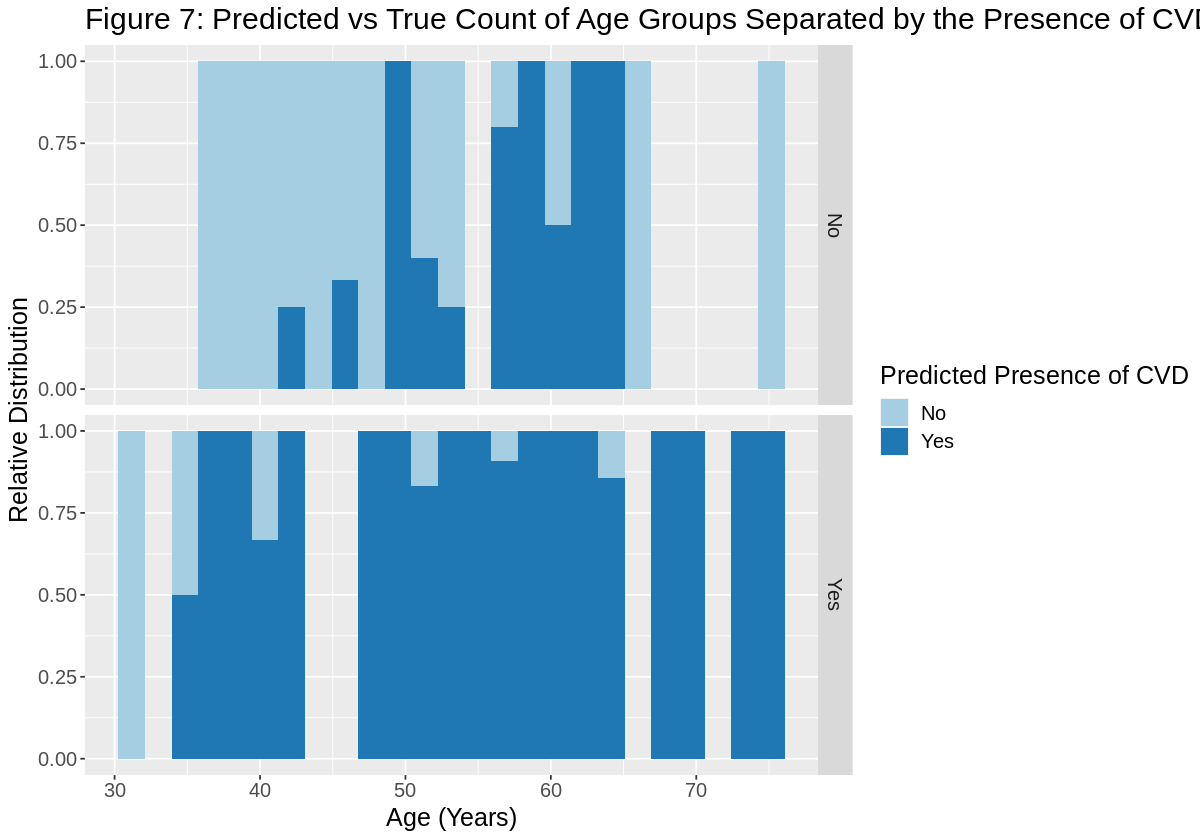

In [14]:
#Age vs. presence of CVD.
options(repr.plot.width = 10, repr.plot.height = 7)
age_vs_pred <- cvd_test_predictions |>
    ggplot(aes(x = age, fill = as_factor(.pred_class))) +
    geom_histogram(bins = 25, position = "fill") + 
    labs(x = "Age (Years)", y = "Relative Distribution", fill = "Predicted Presence of CVD") + theme(text = element_text(size = 15)) +
    ggtitle("Figure 7: Predicted vs True Count of Age Groups Separated by the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired') +
    facet_grid(rows = vars(presence_of_cvd))
age_vs_pred

In Figure 7, the true class vector was passed to the `vars` function in `facet_grid` while, the predicted class vector was set to the `fill`. If we had 100% prediction accuracy, each histogram should only contain one `fill` color. However, we see otherwise. Most of the false positives were located between the ages 50 to 65 years old while there weren't nearly as many false positivies in the same age range. Our classifier could be underfitting for age in this range.

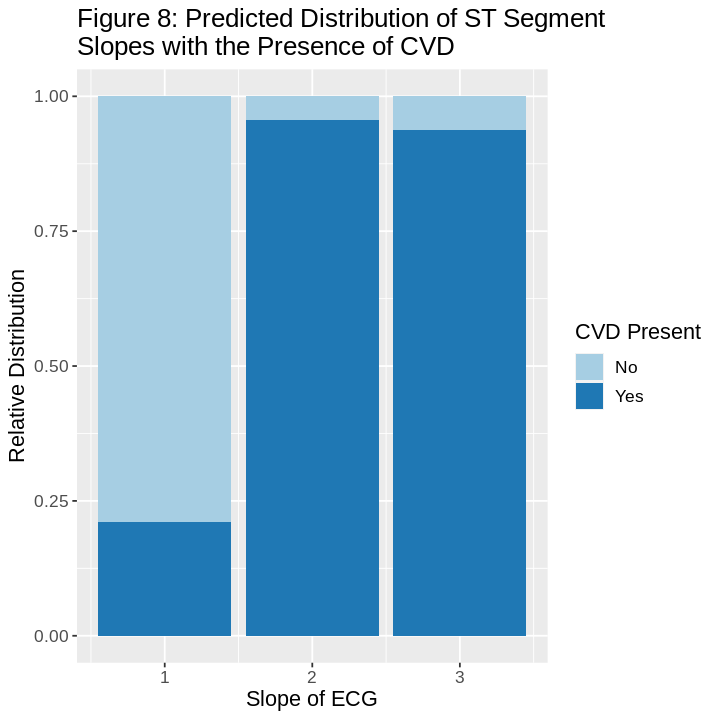

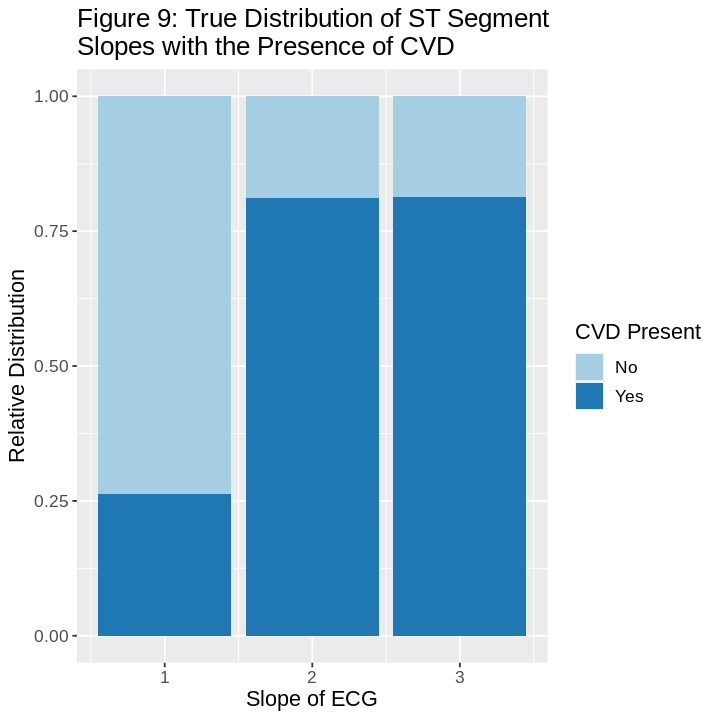

In [15]:
#Predicted and True Class Distribution of ST segment slopes vs. presence of CVD.
options(repr.plot.width = 6, repr.plot.height = 6)
st_segment_slope_plot <- ggplot(cvd_test_predictions, aes(x = st_segment_slope, fill = as_factor(.pred_class))) +
    geom_bar(position = "fill") + 
    labs(x = "Slope of ECG", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 13)) +
    ggtitle("Figure 8: Predicted Distribution of ST Segment \nSlopes with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_segment_slope_plot

st_segment_slope_plot <- ggplot(cvd_test_predictions, aes(x = st_segment_slope, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Slope of ECG", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 13)) +
    ggtitle("Figure 9: True Distribution of ST Segment \nSlopes with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_segment_slope_plot

Comparing Figure 8 and Figure 9, we can see that our classifier is over predicting the presence of CVD in individuals with ST segment slopes >1 and under predicting the presence of CVD in individuals with ST segment slopes equal to 1. This could imply that our classifier is undefitting the data when it comes to using ST segment slope as a predictor.

### Conclusion
In our report, we began by tidying the data to our desired format. Then, we split our data into training and testing sets. To tune our classifier, we performed a 5-fold cross validation to determine the optimal value of k-neighbors. We set our K to 15, and then performed KNN classification on this recipe to yield a result of 82.1% accuracy (Table 4). To be more precise, we had 101 accurate predictions and 22 false predictions (Table 5). The classifier had falsely predicted 16 patients to be positive with CVD, while 6 patients were falsely predicted to be negative (Table 5). 

### Expectations
We expected our classifier to have significantly higher accuracy than our majority classifier (>55%). The results above indicate that our classifier has a higher accuracy by 27%. Thus our expectations were met as we found our classifier to have significantly higher accuracy than our majority classifier. In building our classifier, we had expected it to have a higher accuracy than 82.1% as we were hoping that it could be a method to be used in a practical setting. This means it should have an accuracy of no less than that of legitimate diagnostic methods so an 82.1% accuracy would not suffice. In retrospect, we could have made some alternations to our classifiier that would have improved its accuracy. For example, altering the proportion of our training sets and trying to find the optimal proportion to split our data into training and testing. Additionally, we could have also included more predictors, which could have yielded results with higher accuracy. 

### Impact
Our findings show a potential new way for doctors to initially diagnose CVDs using our classifier. Looking at our data in practical settings, a false negative prediction (falsely diagnosing a patient as healthy) would have far more negative consequences than a false positive prediction (falsely diagnosing a patient to have CVD). Looking at our findings, the probability of a false negative is around 7.6%, while a false positive is 36.6%. Although we had a lower probability of getting a false negative, it is still important to recognize that even one false negative prediction could result in serious consequences. Moreover, while our classifier does indicate a new method of diagnosing CVDs for medical facilities, based on its accuracy, it is still best to use the proper equipment and knowledge instead of our classifier.

### Future Questions
Based on our results from the classifier, this could lead to future questions, such as:
- Could medical facilities that lack the proper equipment use the KNN classification method and other methods to diagnose patients with CVD? 
- Could including and testing more columns increase the chances of having a classifier with a higher accuracy? In other words,  is there a CVD condition that will yield a higher accuracy classifier than thalassemia, which we didn’t include in our chosen columns?

### Citations

1. Simegn, G. L., Gebeyehu, W. B., &amp; Degu, M. Z. (2022). Computer-aided decision support system for diagnosis of heart diseases. Research Reports in Clinical Cardiology, Volume 13, 39–54. https://doi.org/10.2147/rrcc.s366380 
 
2. Bots, S. H., Peters, S. A., &amp; Woodward, M. (2017). Sex differences in coronary heart disease and stroke mortality: A global assessment of the effect of ageing between 1980 and 2010. BMJ Global Health, 2(2). https://doi.org/10.1136/bmjgh-2017-000298 

3. Mayo Foundation for Medical Education and Research. (2022, March 30). Angina. Mayo Clinic. Retrieved December 6, 2022, from https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373 

4. Electrocardiogram. Electrocardiogram | Johns Hopkins Medicine. (2021, August 8). Retrieved December 6, 2022, from https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/electrocardiogram 